### 삼성 주가 불러오기

In [33]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00


In [35]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

In [49]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2022-01-01',
                     end='2022-05-12') # 005930 : 삼성전자 주가

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,76808.171875,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,75539.414062,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,75051.437500,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,76417.781250,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,76125.000000,9947422


### 종가 예측

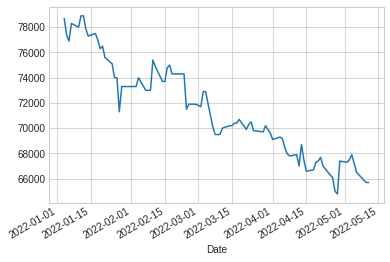

In [50]:
fig = df['Close'].plot()

### decomposition

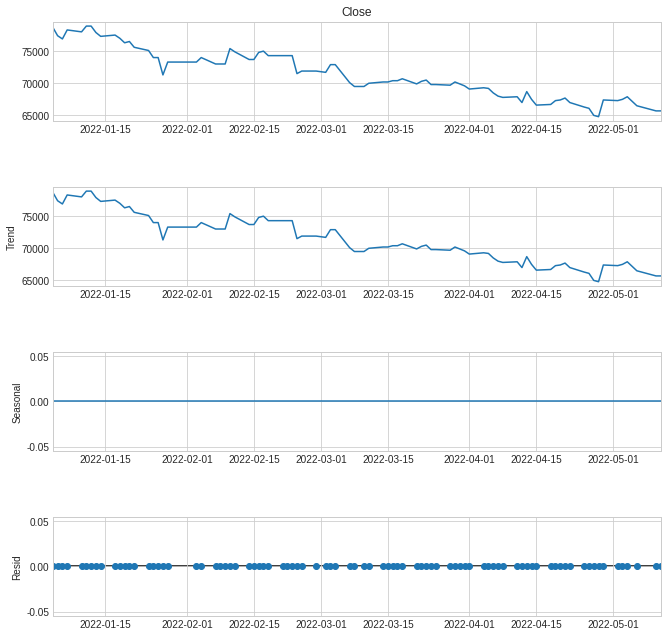

In [51]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

### ACF,PACF

In [52]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

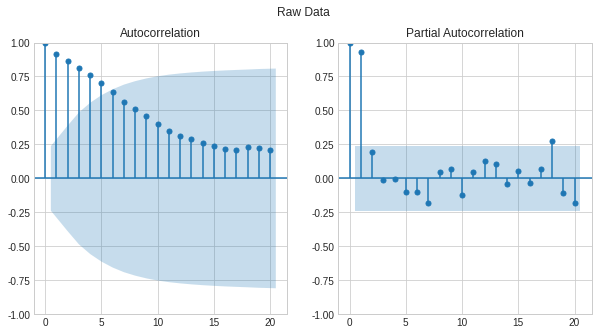

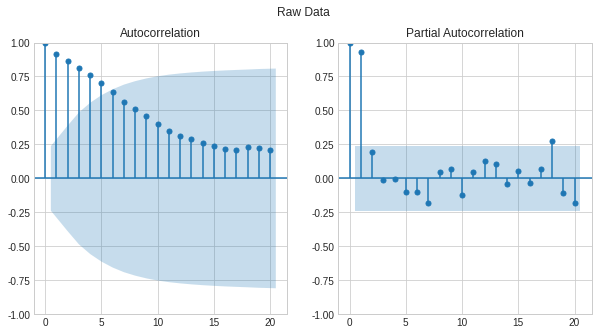

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

### Differencing
### plot을 확인한 결과, ACF이 천천히 감소하는 패턴 -> non-stationary 이므로 차분을 진행한다.

In [54]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print("********Raw data********")
print(train_data['Close'].head())
print("********Differenced data********")
print(diff_train_data.head())

********Raw data********
Date
2022-01-04    78700.0
2022-01-05    77400.0
2022-01-06    76900.0
2022-01-07    78300.0
2022-01-10    78000.0
Name: Close, dtype: float64
********Differenced data********
Date
2022-01-05   -1300.0
2022-01-06    -500.0
2022-01-07    1400.0
2022-01-10    -300.0
2022-01-11     900.0
Name: Close, dtype: float64


### 차분 전,후 시각화

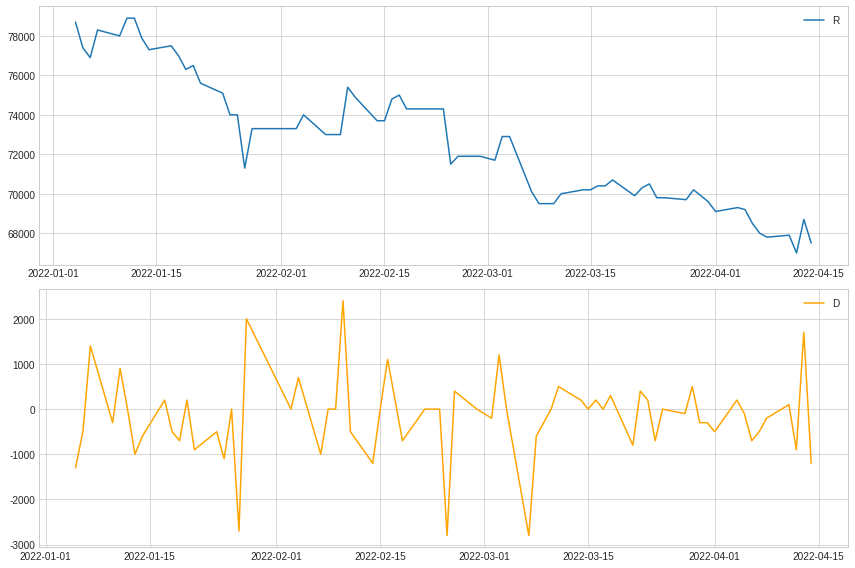

In [55]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

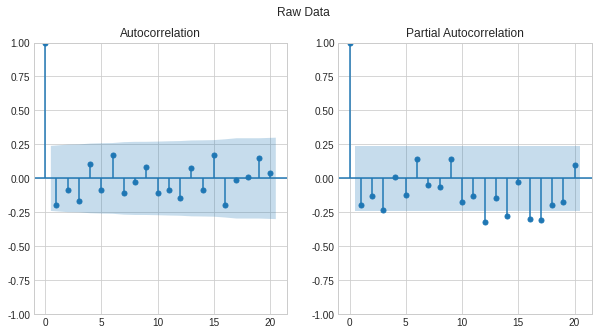

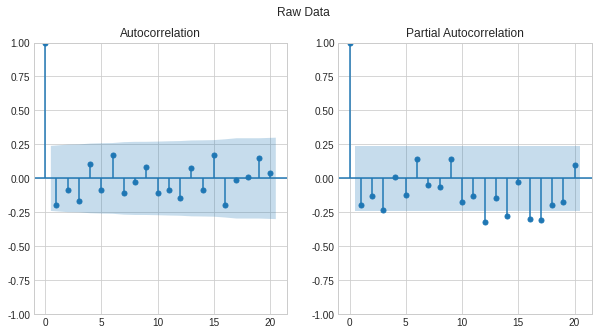

In [56]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

### 최적 파라미터 서치

In [57]:
p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train_data['Close'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 1107.32
ARIMA pdq : (0, 1, 1) >> AIC : 1106.43
ARIMA pdq : (0, 2, 0) >> AIC : 1146.01
ARIMA pdq : (0, 2, 1) >> AIC : 1144.9
ARIMA pdq : (1, 1, 0) >> AIC : 1106.53
ARIMA pdq : (1, 1, 1) >> AIC : 1108.32
ARIMA pdq : (1, 2, 0) >> AIC : 1145.27
ARIMA pdq : (1, 2, 1) >> AIC : 1144.85


In [58]:
# optimal paramter
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 1), 1106.43)]


In [59]:
model = ARIMA(train_data['Close'].values, order=(1, 2, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -569.424
Date:                Tue, 14 Mar 2023   AIC                           1144.847
Time:                        08:42:32   BIC                           1151.416
Sample:                             0   HQIC                          1147.443
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4520      0.276      1.637      0.102      -0.089       0.993
ma.L1         -0.5439      0.290     -1.878      0.060      -1.112       0.024
sigma2      1.785e+06   2.48e+05      7.210      0.000     1.3e+06    2.27e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.59   Jarque-Bera (JB):                 5.81
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.41   Skew:                             0.34
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
pred = model_fit.forecast(len(test_data))
pred.shape

(17,)

In [76]:
pred_index = np.array(list(test_data.index))
pred_index.shape

(17,)

### 예측 시작작

ConversionError: ignored

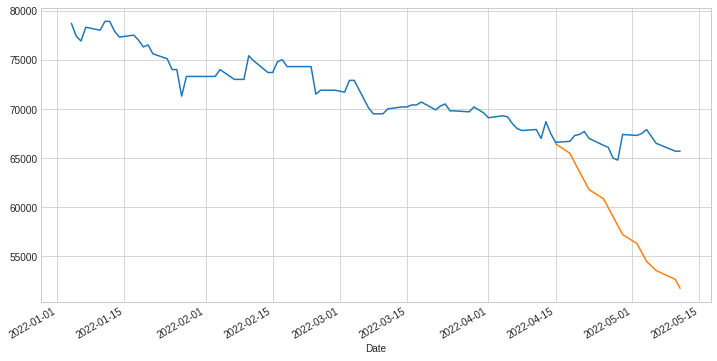

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.plot(pred_index, pred, label='Prediction')
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optim[0][0]}')
plt.show()

### 노란색이 예측, 파란색이 실제 종가다
### 감소 추세는 맞는데 예측값은 실제보다 많이 하락한다
### 정확도가 많이 떨어지는것을 확인인